In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sta457-project-data/SP 500 Historical Data.csv
/kaggle/input/sta457-project-data/final_df1.csv
/kaggle/input/sta457-project-data/Cushing_OK_WTI_Spot_Price_FOB.csv
/kaggle/input/sta457-project-data/Daily Prices_ICCO.csv
/kaggle/input/sta457-project-data/SP 500 Historical Data 2.csv
/kaggle/input/sta457-project-data/Confectionery Product Manufacturing.csv


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch import GradScaler, autocast

import statsmodels.api as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score

import random
import os
import albumentations
from tqdm import tqdm
from datetime import datetime
import pytz
import copy
from copy import deepcopy
import gc

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

print("imports done")

imports done


In [13]:
path = "../input/sta457-project-data/"
df1 = pd.read_csv(path+"final_df1.csv")
df1.set_index("Date", inplace=True)
df1.index = pd.to_datetime(df1.index)
# df1['year'] = df1.index.year
df1

,icco_daily_price,cnft_price,oil_price,sp500_change
Date,,,,
1995-10-03,1372.80,124.100,17.56,0.10
1995-10-04,1381.55,124.100,17.32,-0.14
1995-10-05,1375.45,124.100,16.86,0.19
1995-10-06,1373.33,124.100,17.03,-0.02
1995-10-09,1375.14,124.100,17.36,-0.70
...,...,...,...,...
2025-02-21,9106.42,298.192,70.72,-1.71
2025-02-24,8408.72,298.192,71.06,-0.50
2025-02-25,8668.57,298.192,69.15,-0.47


In [14]:
# following function is taken from: https://youtu.be/q_HS4s1L8UI?si=aTWVN4KqjxnZY6HL

def prepare_dataframe_for_new_analysis(df, n_steps):
    df = deepcopy(df)
    for i in range(n_steps, 0, -1):
        df[f'icco(t-{i})'] = df['icco_daily_price'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
df1 = prepare_dataframe_for_new_analysis(df1, lookback)
df1

,icco_daily_price,cnft_price,oil_price,sp500_change,icco(t-7),icco(t-6),icco(t-5),icco(t-4),icco(t-3),icco(t-2),icco(t-1)
Date,,,,,,,,,,,
1995-10-12,1378.73,124.100,17.08,0.62,1372.80,1381.55,1375.45,1373.33,1375.14,1358.34,1362.39
1995-10-13,1374.23,124.100,17.38,0.24,1381.55,1375.45,1373.33,1375.14,1358.34,1362.39,1378.73
1995-10-16,1389.96,124.100,17.60,-0.26,1375.45,1373.33,1375.14,1358.34,1362.39,1378.73,1374.23
1995-10-17,1401.67,124.100,17.59,0.65,1373.33,1375.14,1358.34,1362.39,1378.73,1374.23,1389.96
1995-10-18,1386.46,124.100,17.57,0.10,1375.14,1358.34,1362.39,1378.73,1374.23,1389.96,1401.67
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-21,9106.42,298.192,70.72,-1.71,10045.51,10010.22,10337.68,10170.58,10123.90,10050.88,9961.58
2025-02-24,8408.72,298.192,71.06,-0.50,10010.22,10337.68,10170.58,10123.90,10050.88,9961.58,9106.42
2025-02-25,8668.57,298.192,69.15,-0.47,10337.68,10170.58,10123.90,10050.88,9961.58,9106.42,8408.72


In [15]:
# fig, ax = plt.subplots(figsize=(15, 5))

# df1["icco_daily_price"].loc[:"2019-04-08"].plot(ax=ax, label='Training Set', title='ICCO Daily Price')
# df1["icco_daily_price"].loc["2019-04-09":"2022-03-15"].plot(ax=ax, label='Validation Set')
# df1["icco_daily_price"].loc["2022-03-16":].plot(ax=ax, label='Test Set')

# ax.axvline('2019-04-09', color='black', ls='--')
# ax.axvline('2022-03-16', color='black', ls='--')
# ax.legend(['Training Set', 'Valid Set', 'Test Set'])
# plt.show()

In [16]:
train_df = df1.loc[:"2019-04-08"]
valid_df = df1.loc["2019-04-09":"2022-03-15"]
test_df = df1.loc["2022-03-16":]

In [17]:
train_df

,icco_daily_price,cnft_price,oil_price,sp500_change,icco(t-7),icco(t-6),icco(t-5),icco(t-4),icco(t-3),icco(t-2),icco(t-1)
Date,,,,,,,,,,,
1995-10-12,1378.73,124.1,17.08,0.62,1372.80,1381.55,1375.45,1373.33,1375.14,1358.34,1362.39
1995-10-13,1374.23,124.1,17.38,0.24,1381.55,1375.45,1373.33,1375.14,1358.34,1362.39,1378.73
1995-10-16,1389.96,124.1,17.60,-0.26,1375.45,1373.33,1375.14,1358.34,1362.39,1378.73,1374.23
1995-10-17,1401.67,124.1,17.59,0.65,1373.33,1375.14,1358.34,1362.39,1378.73,1374.23,1389.96
1995-10-18,1386.46,124.1,17.57,0.10,1375.14,1358.34,1362.39,1378.73,1374.23,1389.96,1401.67
...,...,...,...,...,...,...,...,...,...,...,...
2019-04-02,2317.54,209.0,62.53,0.00,2152.52,2209.89,2222.48,2233.33,2232.91,2249.69,2293.26
2019-04-03,2340.33,209.0,62.46,0.22,2209.89,2222.48,2233.33,2232.91,2249.69,2293.26,2317.54
2019-04-04,2363.93,209.0,62.12,0.21,2222.48,2233.33,2232.91,2249.69,2293.26,2317.54,2340.33


In [18]:
valid_df

,icco_daily_price,cnft_price,oil_price,sp500_change,icco(t-7),icco(t-6),icco(t-5),icco(t-4),icco(t-3),icco(t-2),icco(t-1)
Date,,,,,,,,,,,
2019-04-09,2373.43,209.000,64.05,-0.61,2249.69,2293.26,2317.54,2340.33,2363.93,2362.78,2364.16
2019-04-10,2384.36,209.000,64.62,0.35,2293.26,2317.54,2340.33,2363.93,2362.78,2364.16,2373.43
2019-04-11,2351.36,209.000,63.61,0.00,2317.54,2340.33,2363.93,2362.78,2364.16,2373.43,2384.36
2019-04-12,2383.61,209.000,63.86,0.66,2340.33,2363.93,2362.78,2364.16,2373.43,2384.36,2351.36
2019-04-15,2344.71,209.000,63.43,-0.06,2363.93,2362.78,2364.16,2373.43,2384.36,2351.36,2383.61
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-09,2513.31,229.548,108.81,2.57,2422.96,2405.70,2416.72,2434.35,2473.13,2486.91,2488.10
2022-03-10,2528.14,229.548,105.93,-0.43,2405.70,2416.72,2434.35,2473.13,2486.91,2488.10,2513.31
2022-03-11,2498.46,229.548,109.31,-1.30,2416.72,2434.35,2473.13,2486.91,2488.10,2513.31,2528.14


In [19]:
test_df

,icco_daily_price,cnft_price,oil_price,sp500_change,icco(t-7),icco(t-6),icco(t-5),icco(t-4),icco(t-3),icco(t-2),icco(t-1)
Date,,,,,,,,,,,
2022-03-16,2407.89,229.548,94.85,2.24,2486.91,2488.10,2513.31,2528.14,2498.46,2483.61,2405.01
2022-03-17,2395.39,229.548,102.97,1.23,2488.10,2513.31,2528.14,2498.46,2483.61,2405.01,2407.89
2022-03-18,2425.16,229.548,104.69,1.17,2513.31,2528.14,2498.46,2483.61,2405.01,2407.89,2395.39
2022-03-21,2402.80,229.548,112.14,-0.04,2528.14,2498.46,2483.61,2405.01,2407.89,2395.39,2425.16
2022-03-22,2454.62,229.548,111.03,1.13,2498.46,2483.61,2405.01,2407.89,2395.39,2425.16,2402.80
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-21,9106.42,298.192,70.72,-1.71,10045.51,10010.22,10337.68,10170.58,10123.90,10050.88,9961.58
2025-02-24,8408.72,298.192,71.06,-0.50,10010.22,10337.68,10170.58,10123.90,10050.88,9961.58,9106.42
2025-02-25,8668.57,298.192,69.15,-0.47,10337.68,10170.58,10123.90,10050.88,9961.58,9106.42,8408.72


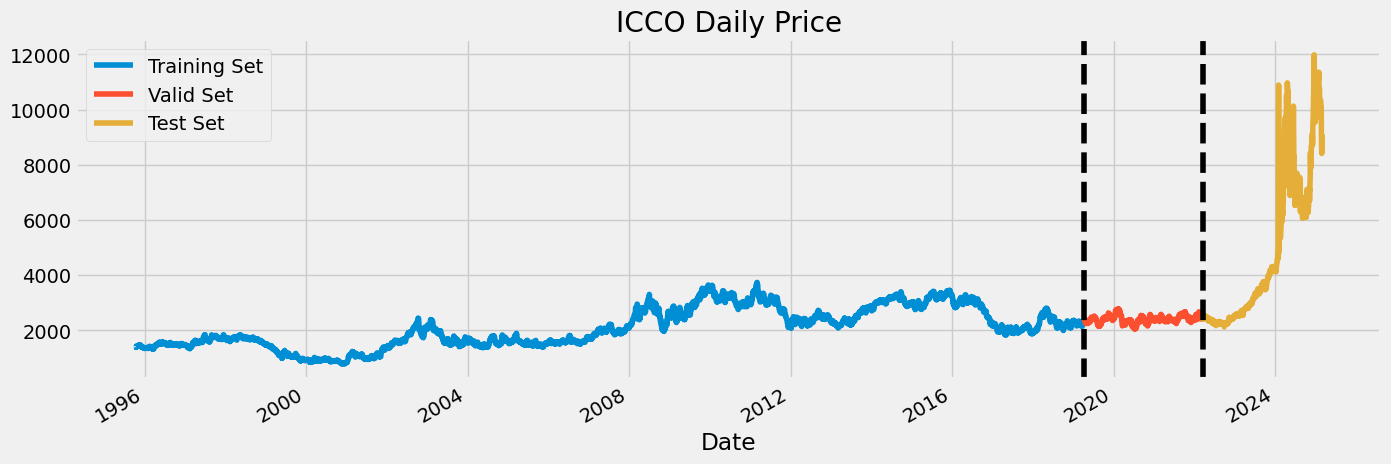

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))

train_df["icco_daily_price"].plot(ax=ax, label='Training Set', title='ICCO Daily Price')
valid_df["icco_daily_price"].plot(ax=ax, label='Validation Set')
test_df["icco_daily_price"].plot(ax=ax, label='Test Set')

ax.axvline('2019-04-09', color='black', ls='--')
ax.axvline('2022-03-16', color='black', ls='--')
ax.legend(['Training Set', 'Valid Set', 'Test Set'])
plt.savefig("train-validation-test-split.png")
plt.show()

In [21]:
X_train = train_df.drop(["icco_daily_price"], axis=1).values
y_train = train_df["icco_daily_price"].values

X_valid = valid_df.drop(["icco_daily_price"], axis=1).values
y_valid = valid_df["icco_daily_price"].values

X_test = test_df.drop(["icco_daily_price"], axis=1).values
y_test = test_df["icco_daily_price"].values

In [22]:
def ml_analysis(X_train, X_valid, y_train, y_valid, verbose=False):
    model_names = ["linear regression", "ridge regression", "elasticnet", "support vector regressor", 
                   "multilayer perceptron", "k-nearest neighbors", "decision tree", "random forest", 
                   "gradient boosting", "xgboost"]
    
    MODELS = {}

    train_dict = {}
    valid_dict = {}
    
    for name in model_names:
        if name == "linear regression":
            model = LinearRegression()
        elif name == "ridge regression":
            model = Ridge()
        elif name == "elasticnet":
            model = ElasticNet()
        elif name == "support vector regressor":
            model = SVR()
        elif name == "multilayer perceptron":
            model = MLPRegressor()
        elif name == "k-nearest neighbors":
            model = KNeighborsRegressor()
        elif name == "decision tree":
            model = DecisionTreeRegressor(random_state=42)
        elif name == "random forest":
            model = RandomForestRegressor(random_state=42)
        elif name == "gradient boosting":
            model = GradientBoostingRegressor(random_state=42)
        elif name == "xgboost":
            model = XGBRegressor(max_depth=2, random_state=42)
        # elif name == "custom ensemble":
        #     rf = RandomForestRegressor(random_state=42)
        #     gbr = GradientBoostingRegressor(random_state=42)
        #     xgb = XGBRegressor(max_depth=2, random_state=42)
        #     lr = LinearRegression()
        #     rr = Ridge()
        #     model = [rf, gbr, xgb, lr, rr, rf, gbr, xgb, rf]
        if not isinstance(model, list):
            model.fit(X_train, y_train)
            train_rmse = mean_squared_error(model.predict(X_train), y_train, squared=False)
            valid_rmse = mean_squared_error(model.predict(X_valid), y_valid, squared=False)
            train_rmsle = mean_squared_log_error(model.predict(X_train), y_train, squared=False)
            valid_rmsle = mean_squared_log_error(model.predict(X_valid), y_valid, squared=False)
            train_mape = mean_absolute_percentage_error(model.predict(X_train), y_train)
            valid_mape = mean_absolute_percentage_error(model.predict(X_valid), y_valid)
            train_r2 = r2_score(model.predict(X_train), y_train)
            valid_r2 = r2_score(model.predict(X_valid), y_valid)
        else:
            train_pred = 0
            valid_pred = 0
            for m in model:
                m.fit(X_train, y_train)
                # print(m)
                # print(mean_squared_error(m.predict(X_train), y_train, squared=False))
                # print(mean_squared_error(m.predict(X_valid), y_valid, squared=False))
                train_pred += m.predict(X_train)
                valid_pred += m.predict(X_valid)
            train_pred = train_pred / len(model)
            valid_pred = valid_pred / len(model)
            train_rmse = mean_squared_error(train_pred, y_train, squared=False)
            valid_rmse = mean_squared_error(valid_pred, y_valid, squared=False)
        train_dict[name] = [train_rmse, train_rmsle, train_mape, train_r2]
        valid_dict[name] = [valid_rmse, valid_rmsle, valid_mape, valid_r2]
        MODELS[name] = model
        if verbose:
            print("model:\t", name)
            print("train_rmse:\t", train_rmse)
            print("valid_rmse:\t", valid_rmse)
            print("train_rmsle:\t", train_rmsle)
            print("valid_rmsle:\t", valid_rmsle)
            print("train_mape:\t", train_mape)
            print("valid_mape:\t", valid_mape)
            print("train_r2:\t", train_r2)
            print("valid_r2:\t", valid_r2)
    return train_dict, valid_dict, MODELS


In [23]:
train_dict, valid_dict, MODELS1 = ml_analysis(X_train, X_valid, y_train, y_valid)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.709e+06, tolerance: 2.997e+05
  model = cd_fast.enet_coordinate_descent(


In [27]:
valid_dict

{'linear regression': [31.272196262044258,
  0.013042380155809155,
  0.010263159898783852,
  0.9447524977897264],
 'ridge regression': [31.27220929469089,
  0.013042387025259753,
  0.01026316859255441,
  0.9447524834649972],
 'elasticnet': [31.793767603144282,
  0.013246435366482973,
  0.010486789428745735,
  0.9429786567961999],
 'support vector regressor': [65.95056087340896,
  0.027433002032396025,
  0.021761756512847744,
  0.7562460296134015],
 'multilayer perceptron': [33.76473423653738,
  0.014075284945130141,
  0.011108659386040061,
  0.9358489770569671],
 'k-nearest neighbors': [43.622284019914986,
  0.01837639112596365,
  0.01449551661414671,
  0.897123906552566],
 'decision tree': [61.37305103719489,
  0.025686318476978255,
  0.019602890090159513,
  0.800934275759112],
 'random forest': [35.82066050543702,
  0.01496761190025777,
  0.011822879845552562,
  0.9274046713059101],
 'gradient boosting': [33.16915104539648,
  0.013840788739610038,
  0.010891759940534807,
  0.93738874

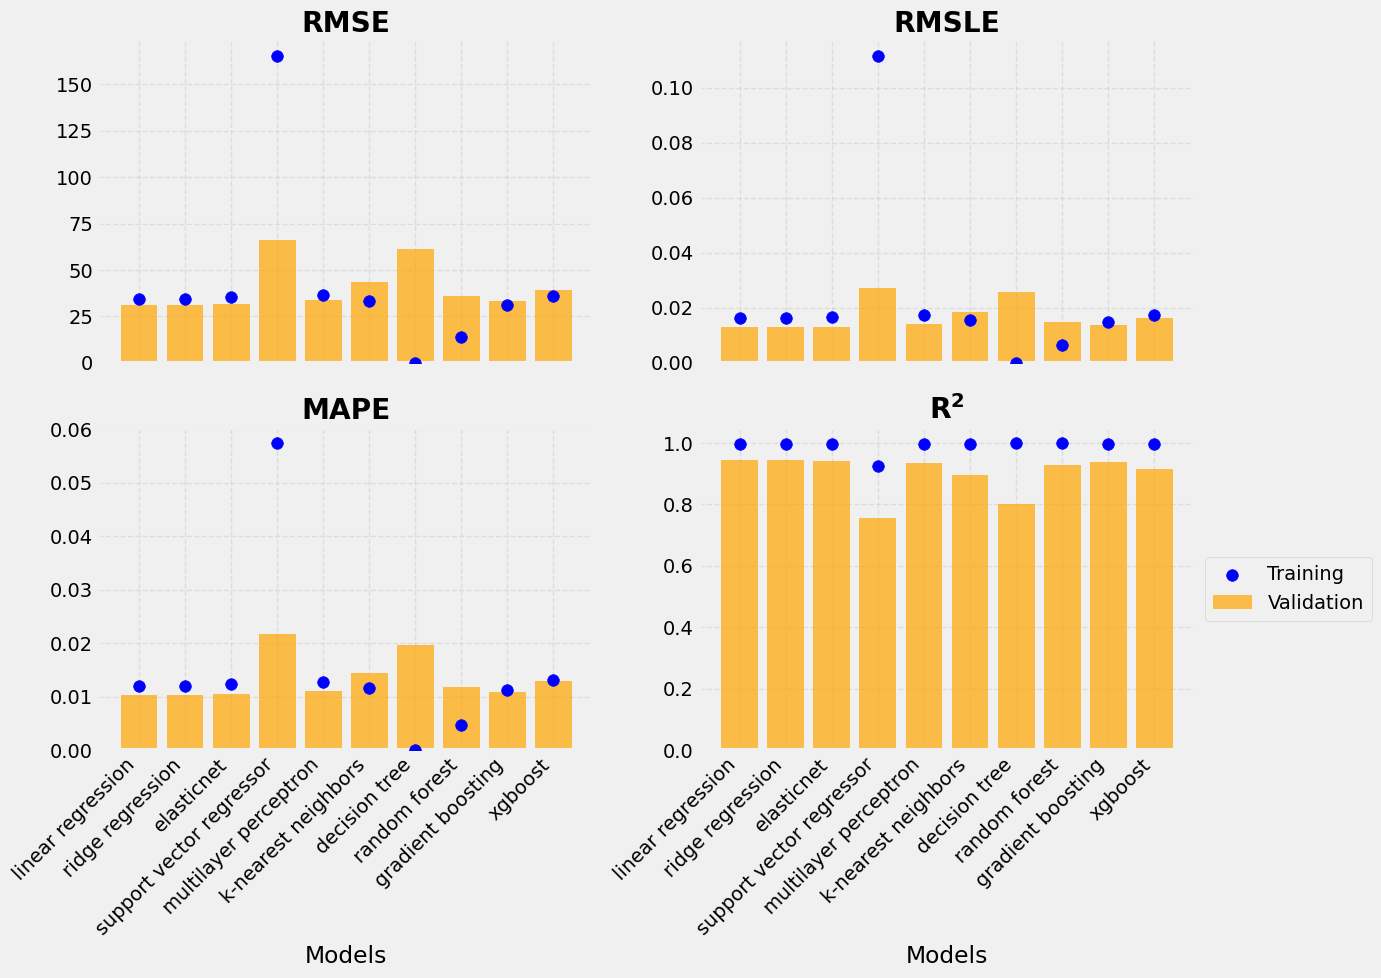

In [24]:
def fn(train_dict, valid_dict, MODELS):
    # Assuming you already ran the ml_analysis function and have the following dictionaries:
    # train_dict: dict with keys = model names and values = [RMSE, RMSLE, MAPE, R²] for training data
    # valid_dict: dict with keys = model names and values = [RMSE, RMSLE, MAPE, R²] for validation data
    
    # Define the metric names in the order they appear in the lists returned by ml_analysis
    metrics = ['RMSE', 'RMSLE', 'MAPE', r'$\mathbf{R^2}$']
    model_names = list(train_dict.keys())
    n_models = len(model_names)
    
    # Prepare data containers for each metric for training and validation
    train_metrics = {metric: [] for metric in metrics}
    valid_metrics = {metric: [] for metric in metrics}
    
    for model in model_names:
        train_vals = train_dict[model]
        valid_vals = valid_dict[model]
        for i, metric in enumerate(metrics):
            train_metrics[metric].append(train_vals[i])
            valid_metrics[metric].append(valid_vals[i])
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()  # Flatten to easily iterate over the axes
    
    x = np.arange(n_models)  # positions for the models on the x-axis
    
    for i, metric in enumerate(metrics):
        ax = axs[i]
        # Plot validation scores as bar plots
        ax.bar(x, valid_metrics[metric], label='Validation', color='orange', alpha=0.7)
        # Plot training scores as scatter points
        ax.scatter(x, train_metrics[metric], label='Training', color='blue', zorder=5, s=70)
        
        # Set the title for each subplot
        ax.set_title(metric, fontweight='bold')
        
        # Only show x-axis tick labels on the bottom row (i.e., subplots with indices 2 and 3)
        if i >= 2:
            ax.set_xticks(x)
            ax.set_xticklabels(model_names, rotation=45, ha="right")
            ax.set_xlabel("Models")
        else:
            # For top plots, use empty tick labels to avoid redundancy
            ax.set_xticks(x)
            ax.set_xticklabels([])
        
        # # Optionally, set y-label on the left column only for clarity
        # if i % 2 == 0:
        #     ax.set_ylabel(metric)
        
        # Add a grid for easier readability
        ax.grid(True, linestyle='--', alpha=0.5)
    
    # Create a common legend for all subplots placed to the right of the figure.
    # Adjust bbox_to_anchor to leave space between the legend and the y-axis ticks.
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    
    # Adjust layout to make room for the legend on the right.
    fig.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig("classical_ml_analysis_scores.png")
    plt.show()


fn(train_dict, valid_dict, MODELS1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


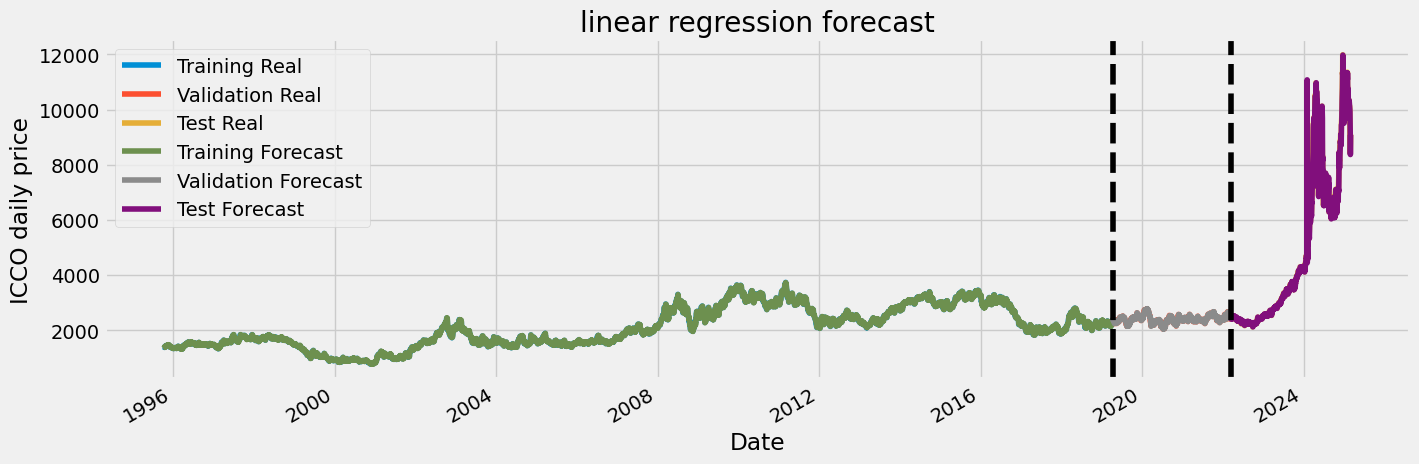

In [30]:
def fn():
    fig, ax = plt.subplots(figsize=(15, 5))

    df1["icco_daily_price"].loc[:"2019-04-08"].plot(ax=ax, label='Training Real', title='linear regression forecast')
    df1["icco_daily_price"].loc["2019-04-09":"2022-03-15"].plot(ax=ax, label='Validation Real')
    df1["icco_daily_price"].loc["2022-03-16":].plot(ax=ax, label='Test Real')

    model = MODELS1["linear regression"]
    X = df1.drop(["icco_daily_price"], axis=1)
    train_pred_df = pd.DataFrame(model.predict(X.loc[:"2019-04-08"]))
    train_pred_df.set_index(df1["icco_daily_price"].loc[:"2019-04-08"].index, inplace=True)
    valid_pred_df = pd.DataFrame(model.predict(X.loc["2019-04-09":"2022-03-15"]))
    valid_pred_df.set_index(df1["icco_daily_price"].loc["2019-04-09":"2022-03-15"].index, inplace=True)
    test_pred_df = pd.DataFrame(model.predict(X.loc["2022-03-16":]))
    test_pred_df.set_index(df1["icco_daily_price"].loc["2022-03-16":].index, inplace=True)

    train_pred_df.plot(ax=ax, label='Training Forecast')
    valid_pred_df.plot(ax=ax, label='Validation Forecast')
    test_pred_df.plot(ax=ax, label='test Forecast')
    
    ax.axvline('2019-04-09', color='black', ls='--')
    ax.axvline('2022-03-16', color='black', ls='--')
    ax.legend(['Training Real', 'Validation Real', 'Test Real', 
               'Training Forecast', 'Validation Forecast', 'Test Forecast'])
    ax.set_ylabel("ICCO daily price")
    plt.savefig("linear regression forecast.png")
    plt.show()



fn()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


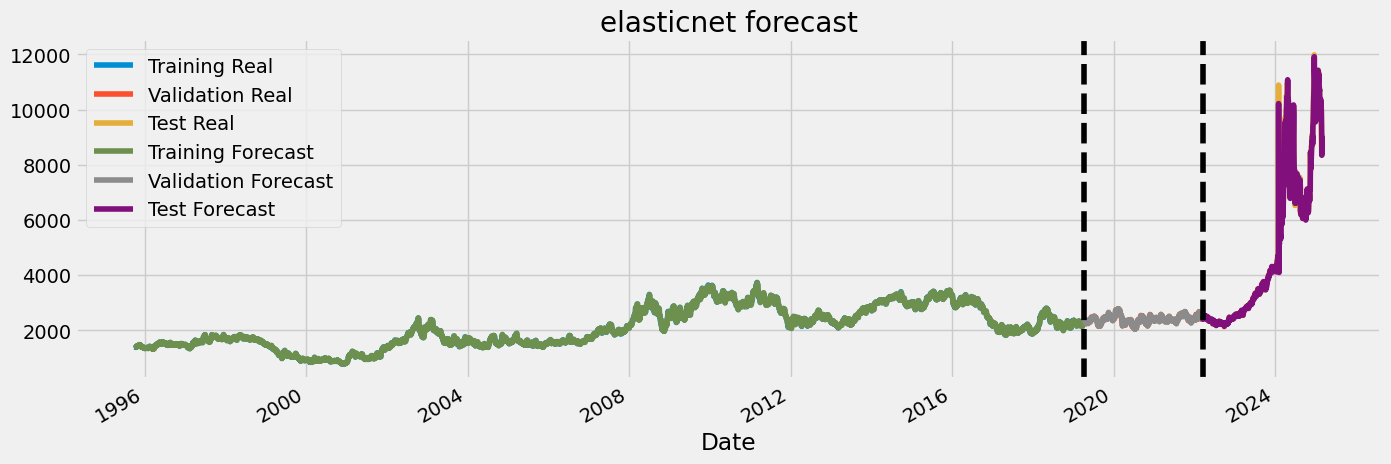

In [26]:
def fn():
    fig, ax = plt.subplots(figsize=(15, 5))

    df1["icco_daily_price"].loc[:"2019-04-08"].plot(ax=ax, label='Training Real', title='elasticnet forecast')
    df1["icco_daily_price"].loc["2019-04-09":"2022-03-15"].plot(ax=ax, label='Validation Real')
    df1["icco_daily_price"].loc["2022-03-16":].plot(ax=ax, label='Test Real')

    model = MODELS1["elasticnet"]
    X = df1.drop(["icco_daily_price"], axis=1)
    train_pred_df = pd.DataFrame(model.predict(X.loc[:"2019-04-08"]))
    train_pred_df.set_index(df1["icco_daily_price"].loc[:"2019-04-08"].index, inplace=True)
    valid_pred_df = pd.DataFrame(model.predict(X.loc["2019-04-09":"2022-03-15"]))
    valid_pred_df.set_index(df1["icco_daily_price"].loc["2019-04-09":"2022-03-15"].index, inplace=True)
    test_pred_df = pd.DataFrame(model.predict(X.loc["2022-03-16":]))
    test_pred_df.set_index(df1["icco_daily_price"].loc["2022-03-16":].index, inplace=True)

    train_pred_df.plot(ax=ax, label='Training Forecast')
    valid_pred_df.plot(ax=ax, label='Validation Forecast')
    test_pred_df.plot(ax=ax, label='test Forecast')
    
    ax.axvline('2019-04-09', color='black', ls='--')
    ax.axvline('2022-03-16', color='black', ls='--')
    ax.legend(['Training Real', 'Validation Real', 'Test Real', 
               'Training Forecast', 'Validation Forecast', 'Test Forecast'])
    plt.savefig("elasticnet forecast.png")
    plt.show()



fn()